In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv("BancaSeries.csv")

data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data["Contagem"] = data.groupby("Produto").cumcount() + 1



In [163]:
data.head()

,Produto,Mes,Contagem
0,Chinelo,2/1/2023,1
1,Chinelo,2/2/2023,2
2,Chinelo,2/3/2023,3
3,Chinelo,2/4/2023,4
4,Bermuda,2/5/2023,1


In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Produto   391 non-null    object
 1   Mes       391 non-null    object
 2   Contagem  391 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ KB


In [165]:
data["Mes"] = pd.to_datetime(data["Mes"], format="mixed", dayfirst=True, errors="coerce")


In [166]:
data.head()

,Produto,Mes,Contagem
0,Chinelo,2023-01-02,1
1,Chinelo,2023-02-02,2
2,Chinelo,2023-03-02,3
3,Chinelo,2023-04-02,4
4,Bermuda,2023-05-02,1


In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Produto   391 non-null    object        
 1   Mes       390 non-null    datetime64[ns]
 2   Contagem  391 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 9.3+ KB


In [168]:
data.isnull().sum()

,0
Produto,0
Mes,1
Contagem,0


In [169]:
data.describe()

,Mes,Contagem
count,390,391.000000
mean,2023-06-30 10:20:18.461538560,42.207161
min,2023-01-02 00:00:00,1.000000
25%,2023-03-17 06:00:00,13.000000
50%,2023-07-10 12:00:00,36.000000
75%,2023-10-07 00:00:00,62.000000
max,2023-12-11 00:00:00,134.000000
std,NaN,34.226853


In [170]:
df_tempo = data.groupby('Mes')['Produto'].count().reset_index()

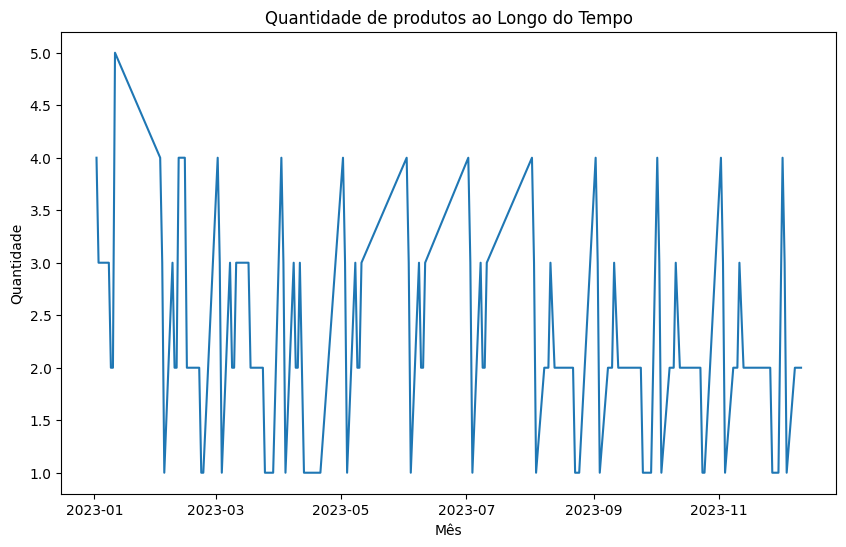

In [171]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_tempo, x='Mes', y='Produto')
plt.title('Quantidade de produtos ao Longo do Tempo')
plt.xlabel('Mês')
plt.ylabel('Quantidade')
plt.show()

In [172]:
from prophet import Prophet

In [173]:
df_prophet = data[['Mes', 'Contagem']].rename(columns={'Mes': 'ds', 'Contagem': 'y'})

df_prophet.head()

,ds,y
0,2023-01-02,1
1,2023-02-02,2
2,2023-03-02,3
3,2023-04-02,4
4,2023-05-02,1


In [174]:
df_prophet = df_prophet.groupby('ds')['y'].sum().reset_index()
df_prophet

,ds,y
0,2023-01-02,26
1,2023-01-03,41
2,2023-01-04,97
3,2023-01-08,59
4,2023-01-09,84
...,...,...
177,2023-12-04,56
178,2023-12-08,37
179,2023-12-09,96
180,2023-12-10,93


In [175]:
np.random.seed(42)



Criando o modelo

In [176]:
modelo = Prophet()

modelo.fit(df_prophet)

futuro = modelo.make_future_dataframe(periods=90, freq='D')
previsoes = modelo.predict(futuro)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3mj1yan/c05edq00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3mj1yan/br50kaok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52831', 'data', 'file=/tmp/tmpi3mj1yan/c05edq00.json', 'init=/tmp/tmpi3mj1yan/br50kaok.json', 'output', 'file=/tmp/tmpi3mj1yan/prophet_modelbsx5ut01/prophet_model-20250823125603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:56:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:56:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


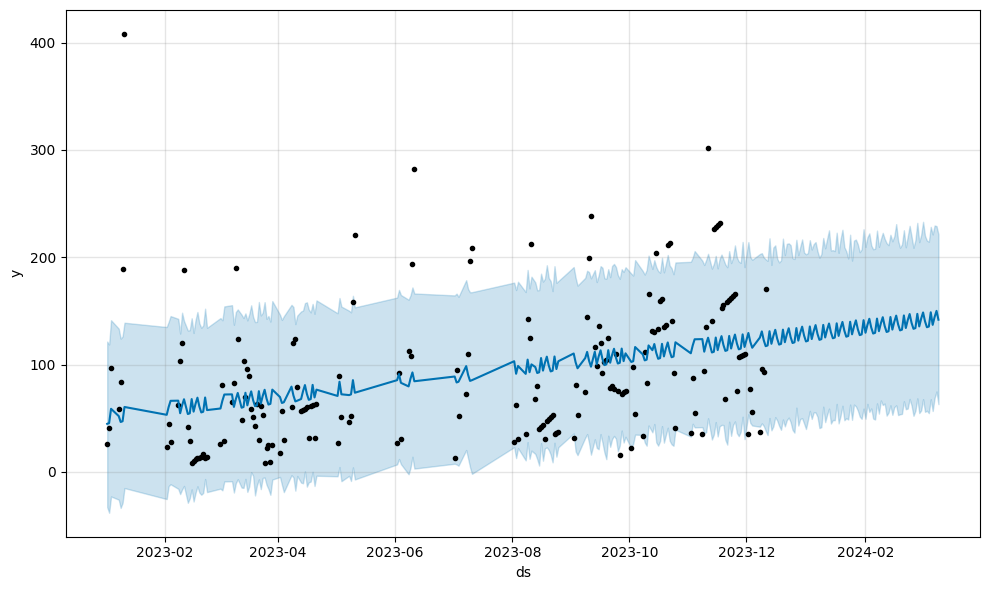

In [177]:
fig1 = modelo.plot(previsoes)

In [178]:
previsoes[['ds','yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2023-01-02,44.754017,-32.962962,121.376734
1,2023-01-03,45.452988,-38.125309,118.702093
2,2023-01-04,58.744559,-22.925722,141.268327
3,2023-01-08,51.971793,-25.909312,133.402610
4,2023-01-09,46.462530,-33.605139,124.147141
...,...,...,...,...
267,2024-03-06,148.663514,67.651367,228.256051
268,2024-03-07,136.948988,56.706420,221.179798
269,2024-03-08,144.234161,68.788041,229.544487
270,2024-03-09,149.977147,74.902308,228.978563


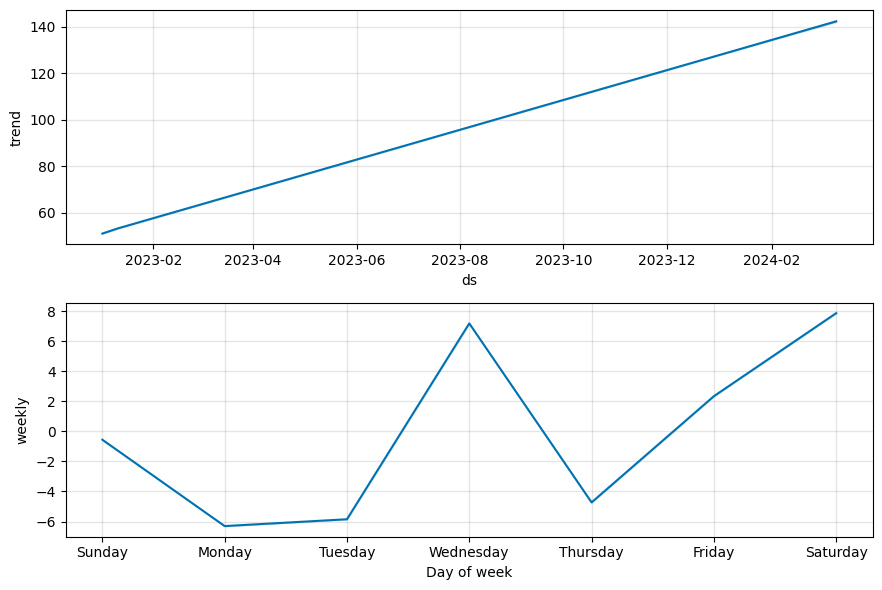

In [179]:
fig2 = modelo.plot_components(previsoes)

In [180]:
  df_prophet.shape

(182, 2)

In [181]:
df_treino = pd.DataFrame()

df_treino['ds'] = df_prophet['ds'][:45]

df_treino['y'] = df_prophet['y'][:45]

In [182]:
df_teste = pd.DataFrame()

df_teste['ds'] = df_prophet['ds'][45:]
df_teste['y'] = df_prophet['y'][45:]

In [183]:
np.random.seed(42)
modelo = Prophet()
modelo.fit(df_treino)

futuro = modelo.make_future_dataframe(periods=180, freq='D')
previsoes = modelo.predict(futuro)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3mj1yan/745e8pwq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3mj1yan/cr2qih4_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27876', 'data', 'file=/tmp/tmpi3mj1yan/745e8pwq.json', 'init=/tmp/tmpi3mj1yan/cr2qih4_.json', 'output', 'file=/tmp/tmpi3mj1yan/prophet_model3ldhc59_/prophet_model-20250823125604.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:56:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


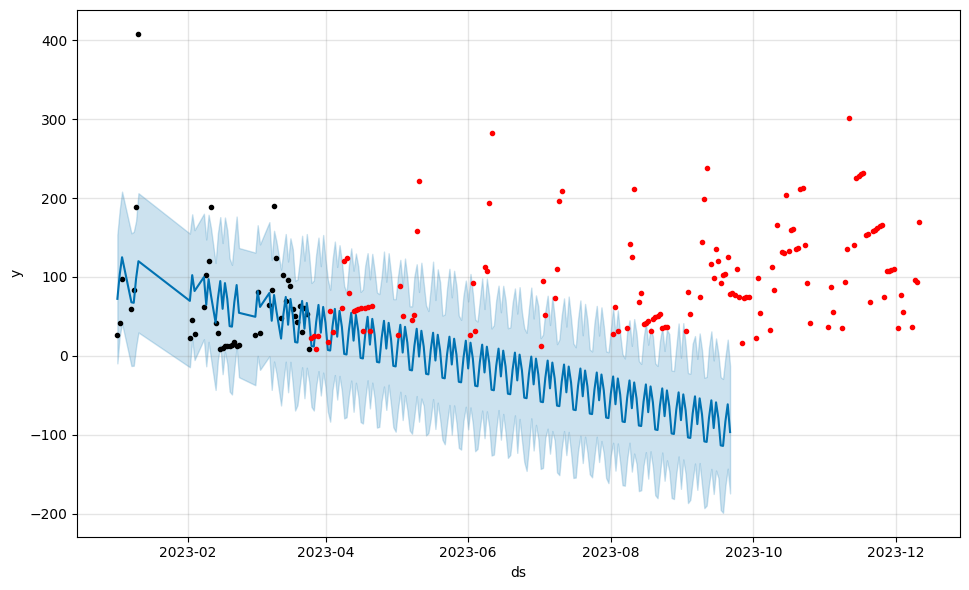

In [184]:
fig1 = modelo.plot(previsoes)
plt.plot(df_teste['ds'],df_teste['y'], '.r' )

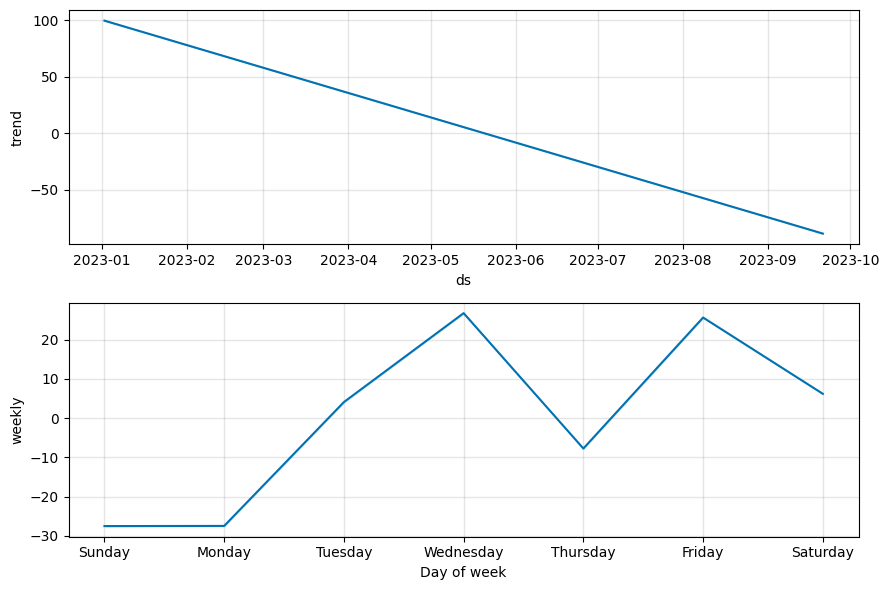

In [185]:
fig2 = modelo.plot_components(previsoes)

Métricas

In [186]:
df_previsao = previsoes[['ds', 'yhat' ]]
df_comparacao = pd.merge(df_previsao, df_teste, on='ds')
df_comparacao

,ds,yhat,y
0,2023-03-26,12.424513,22
1,2023-03-27,11.743950,25
2,2023-03-28,42.576337,9
3,2023-03-29,64.505050,25
4,2023-04-02,7.385728,18
...,...,...,...
72,2023-09-17,-113.545106,92
73,2023-09-18,-114.225669,102
74,2023-09-19,-83.393282,104
75,2023-09-20,-61.464569,125


In [187]:
from sklearn.metrics import mean_squared_error

In [188]:
mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat'])
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 19827.15983289922
RMSE: 140.8089479859118


In [189]:
df_prophet

,ds,y
0,2023-01-02,26
1,2023-01-03,41
2,2023-01-04,97
3,2023-01-08,59
4,2023-01-09,84
...,...,...
177,2023-12-04,56
178,2023-12-08,37
179,2023-12-09,96
180,2023-12-10,93


In [190]:
np.random.seed(42)
modelo = Prophet()
modelo.fit(df_prophet)

futuro = modelo.make_future_dataframe(periods=0)
previsoes = modelo.predict(futuro)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3mj1yan/2ddzn35a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3mj1yan/p062w4up.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15064', 'data', 'file=/tmp/tmpi3mj1yan/2ddzn35a.json', 'init=/tmp/tmpi3mj1yan/p062w4up.json', 'output', 'file=/tmp/tmpi3mj1yan/prophet_modelogeqb4oq/prophet_model-20250823125606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:56:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [191]:
sem_outliers = df_prophet[(df_prophet['y'] > previsoes['yhat_lower']) & (df_prophet['y'] < previsoes['yhat_upper'])]


In [192]:
df_treino['ds'] = df_prophet['ds'][:45]
df_treino['y'] = df_prophet['y'][:45]

df_teste['ds'] = df_prophet['ds'][45:]
df_teste['y'] = df_prophet['y'][45:]

In [193]:
modelo_sem_outliers = Prophet(yearly_seasonality=True)


In [194]:
modelo_sem_outliers = Prophet(yearly_seasonality=True)

modelo_sem_outliers.fit(df_treino)

futuro = modelo_sem_outliers.make_future_dataframe(periods=180, freq='D')
previsoes_sem_outliers = modelo_sem_outliers.predict(futuro)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3mj1yan/3_i34lo0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3mj1yan/qsld431g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50344', 'data', 'file=/tmp/tmpi3mj1yan/3_i34lo0.json', 'init=/tmp/tmpi3mj1yan/qsld431g.json', 'output', 'file=/tmp/tmpi3mj1yan/prophet_modeleju2nnd4/prophet_model-20250823125606.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:56:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


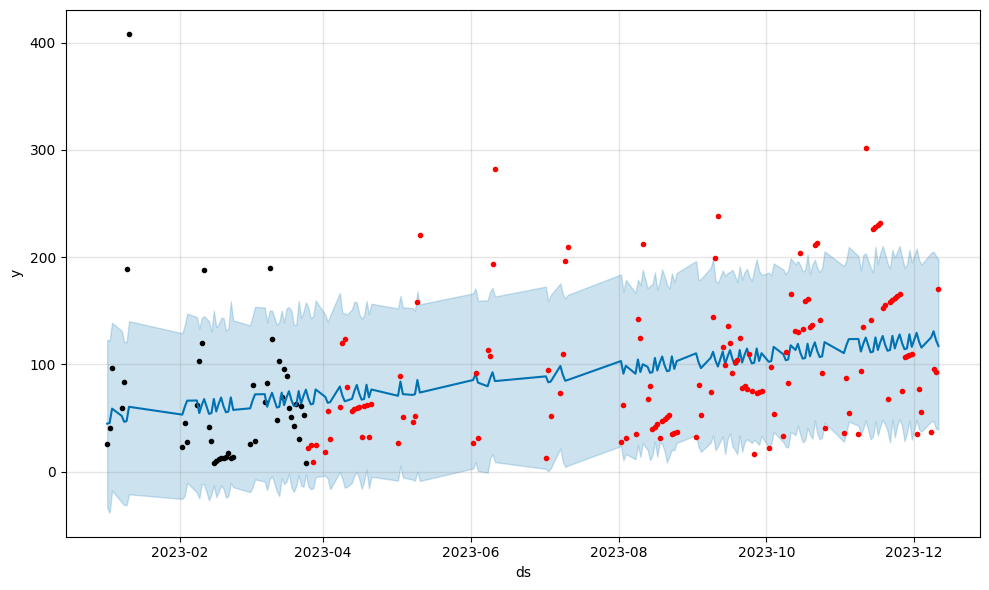

In [195]:
fig1 = modelo_sem_outliers.plot(previsoes)
plt.plot(df_teste['ds'],df_teste['y'], '.r' )

In [196]:
mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat'])
rmse = np.sqrt(mse)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 19827.15983289922, RMSE: 140.8089479859118


In [197]:
np.random.seed(42)
modelo = Prophet()
modelo.fit(df_treino)

futuro = modelo.make_future_dataframe(periods=180, freq='D')
previsoes = modelo.predict(futuro)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3mj1yan/nqk3h6ds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3mj1yan/06h20n4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31414', 'data', 'file=/tmp/tmpi3mj1yan/nqk3h6ds.json', 'init=/tmp/tmpi3mj1yan/06h20n4q.json', 'output', 'file=/tmp/tmpi3mj1yan/prophet_model7x4cj6by/prophet_model-20250823125607.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:56:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:56:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [198]:
from prophet.plot import plot_plotly


In [199]:

fig = plot_plotly(modelo_sem_outliers, previsoes)
fig.show()